# Visualize Patches

To generate sequential patches from one big image, run script in `matter-density-superresolution/exploration-2.ipynb`

rows tensor([True, True, True,  ..., True, True, True])
torch.Size([1024, 1024])
tensor([[0.0235, 0.0118, 0.0157,  ..., 0.0118, 0.0118, 0.0196],
        [0.0157, 0.0157, 0.0275,  ..., 0.0039, 0.0000, 0.0078],
        [0.0118, 0.0235, 0.0275,  ..., 0.0039, 0.0000, 0.0000],
        ...,
        [0.0118, 0.0353, 0.0588,  ..., 0.0039, 0.0078, 0.0118],
        [0.0157, 0.0431, 0.0314,  ..., 0.0039, 0.0078, 0.0157],
        [0.0157, 0.0353, 0.0235,  ..., 0.0039, 0.0078, 0.0196]])


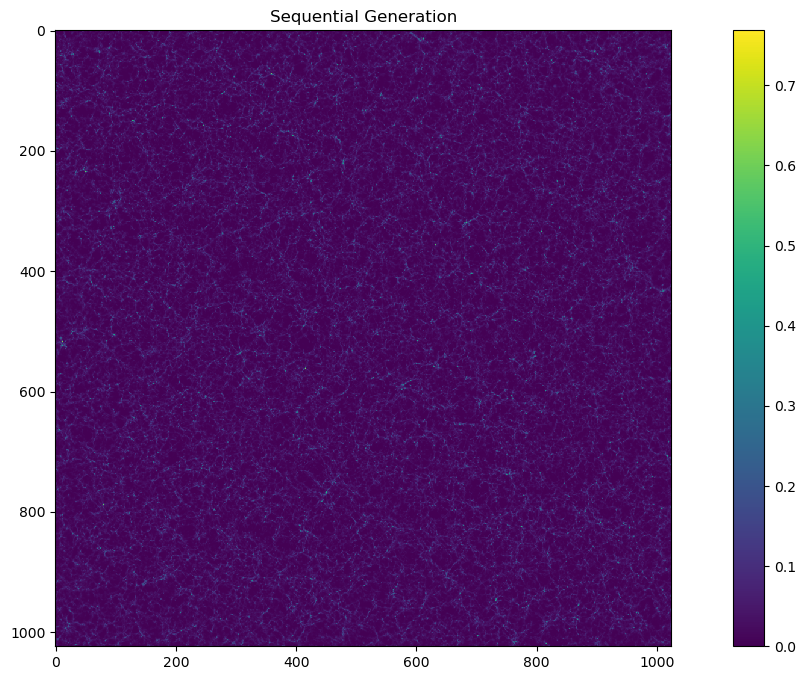

In [1]:
import matplotlib.pyplot as plt
import torch

from compile_patches import compile_patches

def auto_crop(arr):

    # print(torch.all(torch.isfinite(arr), dim=0, keepdim=True))
    not_nan_rows = torch.all(torch.isfinite(arr), dim=1)
    # not_nan_cols = torch.all(torch.isnan(arr), dim=0).sum()
    print('rows', not_nan_rows)
    # print(not_nan_cols)
    # return arr[:not_nan_rows, :not_nan_cols]
    return arr

full = compile_patches(
    directory='../matter-density-superresolution/tile-1/sr',
    i=0,
    full_size=1024,
    patch_size=256,
    stride=256//2,
    apply_mask=True,
    # until_x=0,
    # until_y=128 * 2,
    bg_fill=float('NaN'),
    print_warnings=True
)

crop_x = crop_y = 1024
# crop_x = 256
# crop_y = 1024

figure = plt.figure(figsize=(16, 8))
# figure.suptitle(title)
figure.add_subplot(1, 1, 1)

cropped_full = auto_crop(full)
print(cropped_full.shape)
print(cropped_full)
plt.imshow(cropped_full, interpolation='none')
# plt.imshow(full[:crop_x, :crop_y], interpolation='none')
# plt.clim(scale_min, scale_max)
plt.colorbar()
plt.title('Sequential Generation')
plt.show()

In [4]:
hr = compile_patches(
    directory='../matter-density-superresolution/tile-1/hr',
    i=0,
    full_size=1024,
    patch_size=256,
    stride=256//2,
    apply_mask=True,
    bg_fill=float('NaN'),
    print_warnings=True
)

crop = 1024

figure = plt.figure(figsize=(24 * 2, 8 * 2))
# figure.suptitle(title)

figure.add_subplot(1, 3, 1)
plt.imshow(full[:crop, :crop], interpolation='none')
# plt.clim(scale_min, scale_max)
plt.colorbar()
plt.title('Full Super-Resolution (Model Output)')

figure.add_subplot(1, 3, 2)
plt.imshow(hr[:crop, :crop], interpolation='none')
plt.colorbar()
plt.title('Full High-Resolution (Ground Truth)')

figure.add_subplot(1, 3, 3)
plt.imshow((hr[:crop, :crop] - full[:crop, :crop]), interpolation='none')
plt.colorbar()
plt.title('Diff (SR - HR)')

plt.show()

In [8]:
"""
Save compiled patches to image array
"""
from PIL import Image
import torch
from compile_patches import compile_patches

def save_image(arr, path):
	img = Image.fromarray((arr * 255).type(torch.uint8).numpy(), 'L')
	img.save(path)

dirname = '../matter-density-superresolution/tile-1'
compile_images = ['sr', 'hr', 'lr']
indices = [0, 1]

for index in indices:
	for name in compile_images:
		compiled_image = compile_patches(
			directory=f'{dirname}/{name}',
			i=index,
			full_size=1024,
			patch_size=256,
			stride=256//2,
			apply_mask=True,
			print_warnings=True
		)
		save_path = f'{dirname}/{name}-{index}.png'
		save_image(compiled_image, save_path)
		print(f'Wrote to {save_path}')


Wrote to ../matter-density-superresolution/tile-1/sr-0.png
Wrote to ../matter-density-superresolution/tile-1/hr-0.png
Wrote to ../matter-density-superresolution/tile-1/lr-0.png
Wrote to ../matter-density-superresolution/tile-1/sr-1.png
Wrote to ../matter-density-superresolution/tile-1/hr-1.png
Wrote to ../matter-density-superresolution/tile-1/lr-1.png


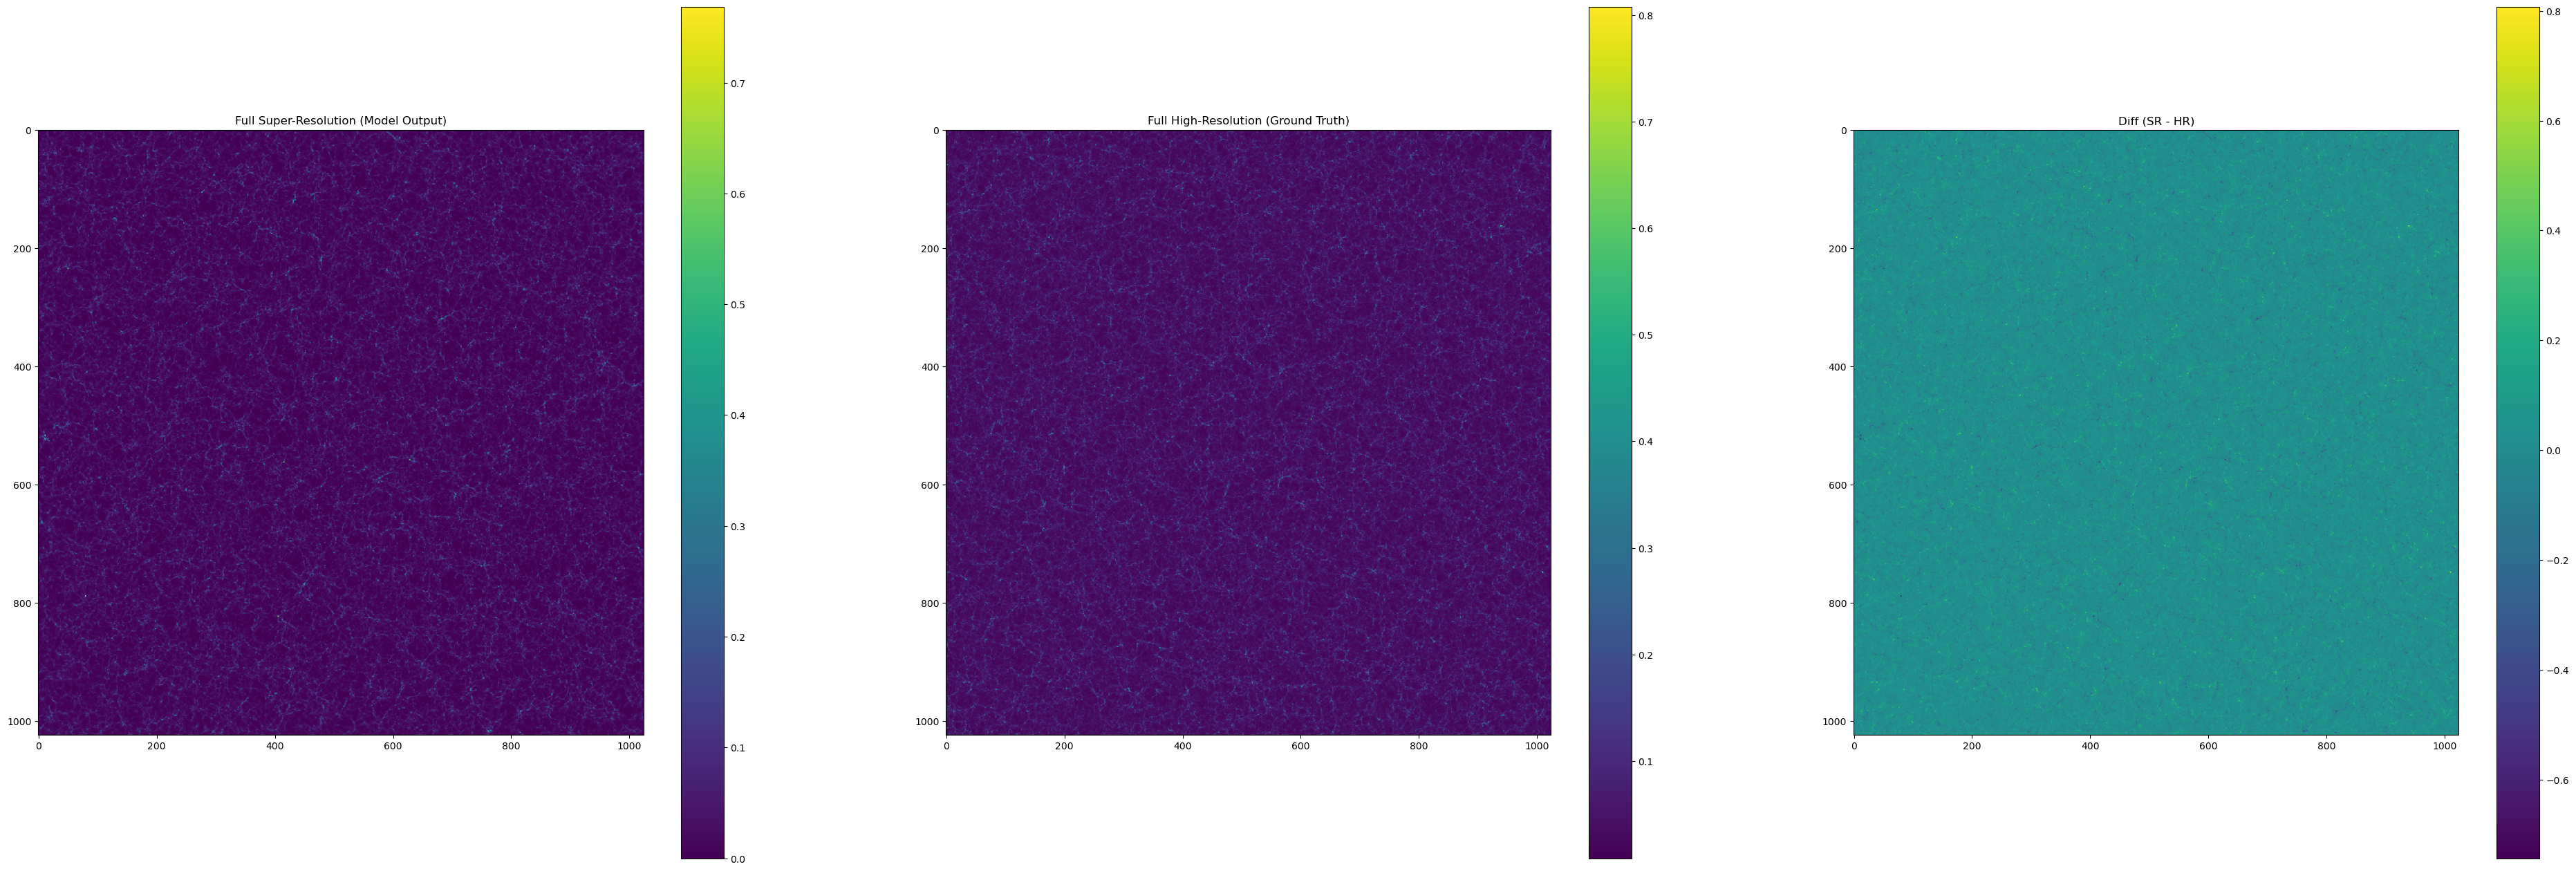

In [2]:
"""
Compare patched together images vs original numpy
"""

import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

def softplus_np(x): return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

tfs = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.Grayscale(num_output_channels=1),
])

data = np.load('../matter-density-superresolution/datasets/first/pairs.npy')
data = softplus_np(data)

min_val = np.amin(data.flatten())
max_val = np.amax(data.flatten())

def normalize(arr):
    return (arr - min_val) / (max_val - min_val)

crop = 256 * 2
crop = 1024

figure = plt.figure(figsize=(24 * 2, 8 * 2))
# figure.suptitle(title)

figure.add_subplot(1, 3, 1)
plt.imshow(full[:crop, :crop], interpolation='none')
# plt.clim(scale_min, scale_max)
plt.colorbar()
plt.title('Full Super-Resolution (Model Output)')

og_hr = normalize(data[10, 0, :crop, :crop])

figure.add_subplot(1, 3, 2)
plt.imshow(og_hr, interpolation='none')
# plt.clim(scale_min, scale_max)
plt.colorbar()
plt.title('Full High-Resolution (Ground Truth)')


full_compare = full[:crop, :crop]
og_compare = torch.tensor(og_hr.astype(np.float32))

figure.add_subplot(1, 3, 3)
plt.imshow((og_compare - full_compare), interpolation='none')
plt.colorbar()
plt.title('Diff (SR - HR)')

plt.show()

In [13]:
"""
Visualize patching process
"""

import imageio
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from os import mkdir, path
from shutil import rmtree

from compile_patches import compile_patches

# Clear animation directory
directory = './animation'
if path.isdir(directory):
    rmtree(directory)
mkdir(directory)

index = 0

full = compile_patches(
    directory='../matter-density-superresolution/tile-1/sr',
    i=index,
    full_size=1024,
    patch_size=256,
    stride=256//2,
    apply_mask=True
)
scale_min = full.amin()
scale_max = full.amax()

full_size = 1024
patch_size = 256
stride = patch_size//2

frame_number = 0
for x_start in range(0, full_size - stride, stride):
        for y_start in range(0, full_size - stride, stride):
            full_frame = compile_patches(
                directory='../matter-density-superresolution/tile-1/sr',
                i=index,
                full_size=full_size,
                patch_size=patch_size,
                stride=stride,
                apply_mask=True,
                until_x=x_start,
                until_y=y_start
            )


            figure = plt.figure(figsize=(8, 8))
            ax = plt.gca()

            plt.imshow(full_frame, interpolation='none')
            plt.clim(scale_min, scale_max)
            plt.colorbar()
            plt.title(f'Sequential Generation for {index}.png')

            rectangles = [Rectangle((y_start, x_start), 256, 256)]
            pc = PatchCollection(rectangles, facecolor='r', edgecolor='r', alpha=0.25)
            ax.add_collection(pc)

            plt.savefig(f'animation/{frame_number}.png')
            plt.close(figure)
            frame_number += 1

# Stitch together into gif
with imageio.get_writer('process.mp4', mode='I', fps=5) as writer:
    for i in range(frame_number):
        filename = f'{directory}/{i}.png'
        image = imageio.imread(filename)
        writer.append_data(image)


C:\Users\micha\AppData\Local\Temp\ipykernel_26276\1466335263.py:72: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
